In [1]:
import gc
import os
import cv2
import math
import base64
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid

from IPython.display import display, HTML, clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# CLIP

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-doxs5fwt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-doxs5fwt
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=53cc7c8dd69252472cb9a1c2885dc5b7a8e5e3fce9de8e6ff2e48398cc420839
  Stored in directory: /tmp/pip-ephem-wheel-cache-ntlhc4wv/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
import torch
from transformers import CLIPTokenizer, CLIPTextModel


def get_tokenizer_and_model(device, eval_mode=True):
    text_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch16')
    text_model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch16').to(device)

    if eval_mode:
        text_model.eval()
    return text_tokenizer, text_model


def get_text_representation(text, text_tokenizer, text_model, device,
                            truncation=True,
                            padding='max_length',
                            max_length=77):
    token_output = text_tokenizer(text,
                                  truncation=truncation,
                                  padding=padding,
                                  return_attention_mask=False,
                                  max_length=max_length)
    indexed_tokens = token_output['input_ids']
    # att_masks = token_output['attention_mask']
    tokens_tensor = torch.tensor(indexed_tokens).to(device)
    # mask_tensor = torch.tensor(att_masks).to(device)
    text_embed = text_model(tokens_tensor).last_hidden_state
    return text_embed

In [ ]:
text_tokenizer, text_model = get_tokenizer_and_model(device='cpu')
empty_text_embed = get_text_representation(['image is a 0', 'image is a 1'], text_tokenizer, text_model, 'cpu')
print(empty_text_embed.shape)
print(empty_text_embed)
print(text_tokenizer.vocab_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


torch.Size([2, 77, 512])
tensor([[[ 0.0134,  0.0697,  0.0683,  ..., -0.3548,  0.1088, -0.3185],
         [-0.2003, -0.0328,  0.7661,  ...,  0.5323, -1.0311, -1.3176],
         [-0.1778, -0.2193,  0.9334,  ..., -0.9395, -0.0730, -1.7119],
         ...,
         [ 1.4869, -1.1443,  0.5272,  ..., -0.2617, -0.7095, -0.5461],
         [ 1.4853, -1.1465,  0.5351,  ..., -0.2473, -0.6947, -0.5676],
         [ 1.5403, -1.1156,  0.4150,  ..., -0.1113, -0.6882, -0.4369]],

        [[ 0.0134,  0.0697,  0.0683,  ..., -0.3548,  0.1088, -0.3185],
         [-0.2003, -0.0328,  0.7661,  ...,  0.5323, -1.0311, -1.3176],
         [-0.1778, -0.2193,  0.9334,  ..., -0.9395, -0.0730, -1.7119],
         ...,
         [ 1.5796, -1.0791,  0.4929,  ..., -0.2897, -0.7682, -0.5033],
         [ 1.5760, -1.0828,  0.4977,  ..., -0.2744, -0.7525, -0.5215],
         [ 1.6377, -1.0315,  0.3733,  ..., -0.1448, -0.7426, -0.3958]]],
       grad_fn=<NativeLayerNormBackward0>)
49408


# UNet

In [27]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)


class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)

        # group 2
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None]

        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)
        return h


class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)


class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x, *args):
        return self.upsample(x)

class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab: int, n_embd: int, n_token: int):
        super().__init__()

        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        # A learnable weight matrix encodes the position information for each token
        self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embd)))

    def forward(self, tokens):
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x = self.token_embedding(tokens)
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x += self.position_embedding

        return x


class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=64,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=2,
        n_vocab=14,
        n_emb=128
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)
        self.embedding = nn.Embedding(n_vocab, n_emb)
        # self.pool = nn.AdaptiveAvgPool2d(n_emb)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)

                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t, text):
        print(t.shape)

        time_emb = self.time_embeddings(t)
        print(time_emb.shape)

        text_emb = self.embedding(text)
        print(text_emb.shape)

        text_emb = text_emb.mean(dim=-2)
        print(text_emb.shape)

        # text_emb = self.pool(text)

        # text_emb = self.time_embeddings(t)
        # print(text_emb.shape)

        h = self.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb + text_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h


# Diffusion

In [3]:
class Diffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 32, 32),
        device="cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device

        self.initialize()

    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta

        self.sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)

    def get_betas(self):
        """linear schedule, proposed in original ddpm paper"""
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )

def forward_diffusion(sd: Diffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    eps = torch.randn_like(x0)  # Noise
    mean    = get(sd.sqrt_alpha_cumulative, t=timesteps) * x0  # Image scaled
    std_dev = get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps) # Noise scaled
    sample  = mean + std_dev * eps # scaled inputs * scaled noise

    return sample, eps  # return ... , gt noise --> model predicts this)

In [4]:
def get(x: torch.Tensor, t: torch.Tensor):
  # print(x.get_device(), t.get_device())
  return x.gather(-1, t).reshape(-1, 1, 1, 1)

In [ ]:
class Diffusion:
  def __init__(self, timesteps=1000, img_shape=(3, 64, 64), device='cpu'):
    self.timesteps = timesteps
    self.img_shape = img_shape
    self.device = device

    self.initialize()

  def get_betas(self, start=1e-4, end=0.02):
    return torch.linspace(start, end, self.timesteps)

  def initialize(self):
    self.betas = self.get_betas().to(self.device)
    self.alphas = 1 - self.betas

    self.alpha_hat = torch.cumprod(self.alphas, dim=0)
    self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
    self.sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat)
    self.one_by_sqrt_alpha = 1. / torch.sqrt(self.alphas)
    self.sqrt_beta = torch.sqrt(self.betas)


def get(x: torch.Tensor, t: torch.Tensor):
  # print(x.get_device(), t.get_device())
  return x.gather(-1, t).reshape(-1, 1, 1, 1)

def forward_diffusion(d: Diffusion, x0: torch.Tensor, t: torch.Tensor):
  eps = torch.randn_like(x0)
  # print(d.alpha_hat.get_device(), x0.get_device(), t.get_device())
  xt = get(d.sqrt_alpha_hat, t) * x0 + get(d.sqrt_one_minus_alpha_hat, t) * eps
  # xt = torch.sqrt(d.alpha_hat[t])[:, None, None, None] * x0 + torch.sqrt(1. - d.alpha_hat[t])[:, None, None, None] * eps
  return xt, eps

In [5]:
def get_data(batch_size=32, num_workers=0, pin_memory=False, device="cpu"):
  transforms = TF.Compose(
        [
            TF.ToTensor(),
            TF.Resize((32, 32),
                      interpolation=TF.InterpolationMode.BICUBIC,
                      antialias=True),
            TF.RandomHorizontalFlip(),
            TF.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
        ]
  )

  dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

  return dataloader

def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

100%|██████████| 170498071/170498071 [00:03<00:00, 49232016.67it/s]


Extracting data/cifar-10-python.tar.gz to data


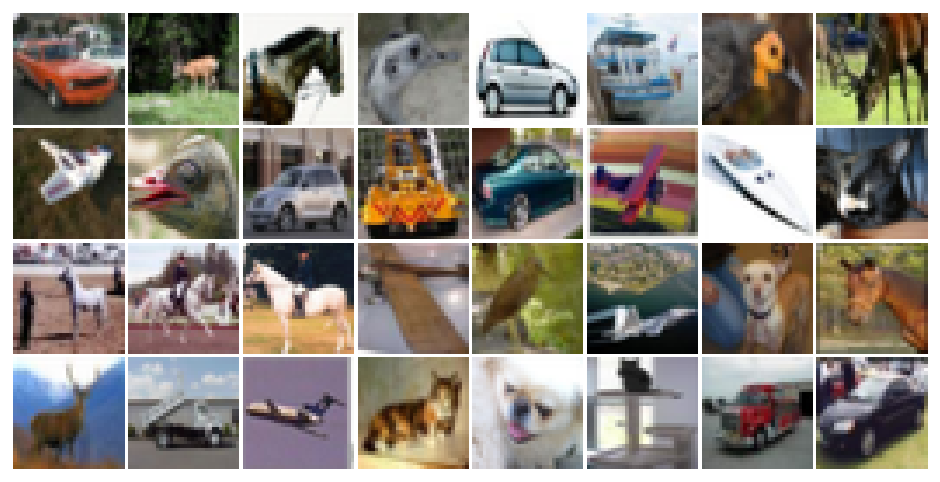

In [6]:
plt.figure(figsize=(12, 6), facecolor='white')
loader = get_data()

for b_image, _ in loader:
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=8, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [7]:
def make_dirs():
  os.makedirs('/models', exist_ok=True)
  os.makedirs('/images', exist_ok=True)
  # os.makedirs(os.path.join('models' + name), exists_ok=True)
  # os.makedirs(os.path.join('images' + name), exists_ok=True)
make_dirs()

Files already downloaded and verified
tensor([1, 9, 4, 6, 8, 9])


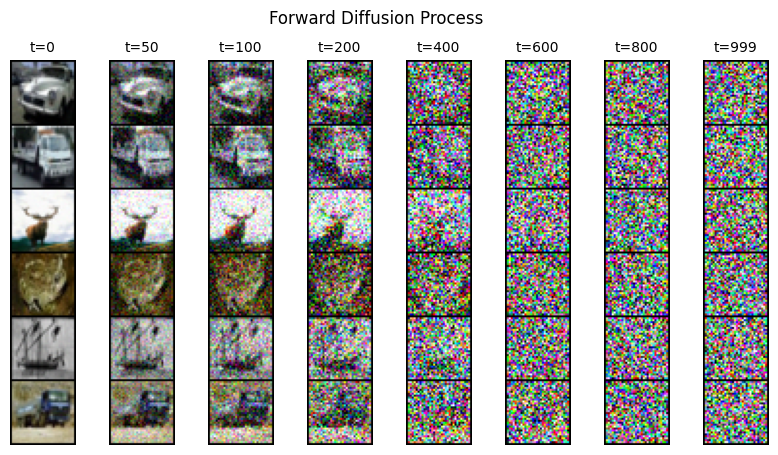

In [8]:
d = Diffusion()

noisy_imgs = []
timesteps = [0, 50, 100, 200, 400, 600, 800, 999]
loader = get_data(6)

for img, c in loader:
  print(c)
  for timestep in timesteps:
    timestep = torch.as_tensor([timestep] * img.shape[0], dtype=torch.long)

    img_with_noise, _ = forward_diffusion(d, img, timestep)
    img_with_noise = inverse_transform(img_with_noise) / 255.
    img_with_noise = make_grid(img_with_noise, nrow=1, padding=1)

    noisy_imgs.append(img_with_noise)
  break

_, ax = plt.subplots(1, len(noisy_imgs), figsize=(10, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(timesteps, noisy_imgs)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=10)
    ax[i].axis("off")
    # ax[i].grid(False)

plt.suptitle("Forward Diffusion Process")
plt.axis("off")
plt.show()


# Training

In [9]:
!pip install torchmetrics
from torchmetrics import MeanMetric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 6.6 MB/s eta 0:00:00


In [18]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")
class_names = np.arange(10)

# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

tokens = set()
tokens.update(*[tokenizer(f"a photo of a {name}") for name in class_names])
tokens = list(tokens)
print(len(tokens))

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(tokens), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
vocab(['a', 'photo', 'of', 'cat'])

13


[11, 13, 12, 0]

In [19]:
# Training

def train_one_epoch(d, model, device, loader, optimizer, epoch, loss_func, scaler, epochs=50, timesteps=1000):
  epoch_loss = MeanMetric()
  model.train()
  # clip_model, preprocess = clip.load("ViT-B/32", device=device)
  # text_tokenizer, text_model = get_tokenizer_and_model(device=device)

  with tqdm(total=len(loader), dynamic_ncols=True) as tq:
    tq.set_description(f'Train :: Epoch: {epoch}/{epochs}')

    for x0, class_name in loader:
      tq.update(1)
      x0 = x0.to(device)

      text_inputs = []

      for name in class_name:
          text_inputs.append(vocab(f"a photo of a {name}".split()))
      text_inputs = torch.tensor(text_inputs).to(device)
      print(text_inputs.shape)

      # text_inputs = torch.cat([clip.tokenize(f"a photo of a {name}") for name in class_name]).to(device)
      # text_inputs = get_text_representation([f"a photo of a {name}" for name in class_name], text_tokenizer, text_model, device).to(device).long()
      # text_inputs = torch.tensor([tokenizer(f"a photo of a {name}") for name in class_names])

      # print(len(text_inputs))

      # text_features = clip_model.encode_text(text_inputs)
      # print(text_features.shape)


      t = torch.randint(low=1, high=timesteps, size=(x0.shape[0],), device=device)
      xt, noise = forward_diffusion(d, x0, t)

      with amp.autocast():
        pred_noise = model(xt, t, text_inputs)
        loss = loss_func(noise, pred_noise)

      optimizer.zero_grad(set_to_none=True)
      scaler.scale(loss).backward()

      scaler.step(optimizer)
      scaler.update()

      loss_val = loss.detach().item()

      tq.set_postfix_str(s=f'Loss: {loss_val: .5f}')

      epoch_loss.update(loss_val)

    tq.set_postfix_str(s=f'Epoch loss: {epoch_loss.compute().item()}')

  return epoch_loss

In [ ]:
class_name = torch.randint(0, 10, (15,), device="cpu")
class_name

tensor([1, 4, 7, 6, 6, 6, 7, 7, 3, 4, 3, 6, 9, 9, 9])

In [12]:
# # Sampling

# @torch.inference_mode()
# def sampling(model, d, num_images=32, nrows=8, device="cuda"):
#     model.eval()

#   # with torch.no_grad():
#     x = torch.randn((num_images, *d.img_shape), device=device)
#     class_name = torch.randint(0, 10, (num_images,), device=device)
#     print(class_name)

#     for i in tqdm(reversed(range(1, d.timesteps)), total=d.timesteps-1, dynamic_ncols=False, desc="Sampling :: ", position=0):
#         t = (torch.ones(num_images) * i).long().to(device)
#         # class_name = torch.randn(num_images, device=device)
#         # class_name = torch.randint(0, 10, (num_images,), device=device)
#         # print(class_name)

#         predicted_noise = model(x, t, class_name)

#         one_by_sqrt_alpha_t = get(d.one_by_sqrt_alpha, t)
#         sqrt_one_minus_alpha_hat_t = get(d.sqrt_one_minus_alpha_hat, t)
#         sqrt_beta_t = get(d.sqrt_beta, t)
#         beta_t = get(d.betas, t)

#         if i > 1:
#             noise = torch.randn_like(x)
#         else:
#             noise = torch.zeros_like(x)
#         x = one_by_sqrt_alpha_t * (x - (beta_t / sqrt_one_minus_alpha_hat_t) * predicted_noise) + sqrt_beta_t * noise

#     model.train()
#     x = inverse_transform(x).type(torch.uint8)
#     grid = torchvision.utils.make_grid(x, nrow=8, pad_value=255.0).to("cpu")
#     pil_image = TF.functional.to_pil_image(grid)
#     # pil_image.save(kwargs['save_path'], format=save_path[-3:].upper())
#     display(pil_image)
#     # x = (x.clamp(-1, 1) + 1) / 2
#     # x = (x * 255).type(torch.uint8)
#     return x

# Sampling

@torch.inference_mode()
def sampling(model, d, num_images=32, nrows=8, device="cuda"):
    x = torch.randn((num_images, *d.img_shape), device=device)
    # class_name = torch.ones(num_images, dtype=torch.long, device=device) * 7
    # class_name = torch.ones(num_images, dtype=torch.long, device=device) * 0

    # class_name = torch.randint(0, 10, (num_images,), device=device)
    # text_inputs = torch.cat([clip.tokenize(f"a photo of a {name}") for name in class_name]).to(device)

    # print(text_inputs.shape)
    text_inputs = []

    for name in class_name:
          text_inputs.append(vocab(f"a photo of a {name}".split()))
    text_inputs = torch.tensor(text_inputs).to(device)
    print(text_inputs.shape)

    model.eval()

  # with torch.no_grad():

    for i in tqdm(reversed(range(1, d.num_diffusion_timesteps)), total=d.num_diffusion_timesteps-1, dynamic_ncols=False, desc="Sampling :: ", position=0):
        t = (torch.ones(num_images) * i).long().to(device)
        predicted_noise = model(x, t, text_inputs)

        one_by_sqrt_alpha_t = get(d.one_by_sqrt_alpha, t)
        sqrt_one_minus_alpha_hat_t = get(d.sqrt_one_minus_alpha_cumulative, t)
        sqrt_beta_t = get(d.sqrt_beta, t)
        beta_t = get(d.beta, t)

        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        x = one_by_sqrt_alpha_t * (x - (beta_t / sqrt_one_minus_alpha_hat_t) * predicted_noise) + sqrt_beta_t * noise

    model.train()
    x = inverse_transform(x).type(torch.uint8)
    grid = torchvision.utils.make_grid(x, nrow=8, pad_value=255.0).to("cpu")
    pil_image = TF.functional.to_pil_image(grid)
    # pil_image.save(kwargs['save_path'], format=save_path[-3:].upper())
    display(pil_image)
    # x = (x.clamp(-1, 1) + 1) / 2
    # x = (x * 255).type(torch.uint8)
    return x



In [28]:
model = UNet()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

loader = get_data(batch_size=128, num_workers=2, pin_memory=True, device=device)

d = Diffusion(device=device)
scaler = amp.GradScaler()
epochs = 50

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [16]:
def save_images(images, path, **kwargs):
  grid = torchvision.utils.make_grid(images, **kwargs)
  ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
  im = Image.fromarray(ndarr)
  im.save(path)

In [29]:
for epoch in range(1, epochs + 1):
  torch.cuda.empty_cache()
  gc.collect()

  train_one_epoch(d, model, device, loader, optimizer, epoch, loss_func, scaler, epochs)
  if epoch % 5 == 0:
    res = sampling(model, d)

    checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
    }

    torch.save(checkpoint_dict, os.path.join("/models", f"ckpt.tar"))
    del checkpoint_dict

    save_images(res, os.path.join("/images", f"{epoch}.jpg"))



Train :: Epoch: 1/50:   0%|          | 1/391 [00:00<00:57,  6.80it/s]/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


torch.Size([128, 5])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128, 5, 128])
torch.Size([128, 128])


Train :: Epoch: 1/50:   0%|          | 1/391 [00:51<5:37:46, 51.96s/it]


KeyboardInterrupt: 

# Inference

In [ ]:
model = UNet()
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scaler = amp.GradScaler()

d = Diffusion(device=device)

loss_func = nn.MSELoss()
loader = get_data(batch_size=128, num_workers=2, pin_memory=True, device=device)

checkpoint = torch.load('/content/drive/MyDrive/ckpt.tar')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['opt'])
scaler.load_state_dict(checkpoint['scaler'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.train()

Files already downloaded and verified


UNet(
  (time_embeddings): SinusoidalPositionEmbeddings(
    (time_blocks): Sequential(
      (0): Embedding(1000, 64)
      (1): Linear(in_features=64, out_features=128, bias=True)
      (2): SiLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (encoder_blocks): ModuleList(
    (0-1): 2 x ResnetBlock(
      (act_fn): SiLU()
      (normlize_1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (dense_1): Linear(in_features=128, out_features=64, bias=True)
      (normlize_2): GroupNorm(8, 64, eps=1e-05, affine=True)
      (dropout): Dropout2d(p=0.1, inplace=False)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (match_input): Identity()
      (attention): Identity()
    )
    (2): DownSample(
      (downsample): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


Sampling :: 100%|██████████| 999/999 [01:16<00:00, 13.04it/s]


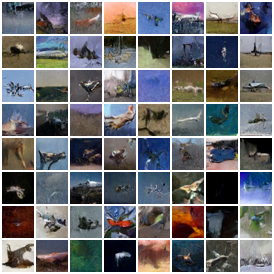

In [ ]:
res = sampling(model, d, num_images=64)
save_images(res, '/content/res1.jpg')

Train :: Epoch: 5/5: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s, Epoch loss: 0.03097216784954071]


tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0')


Sampling :: 100%|██████████| 999/999 [00:47<00:00, 21.11it/s]


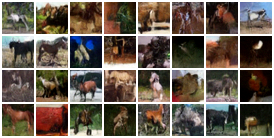

In [ ]:
for epoch in range(1, 6):
  torch.cuda.empty_cache()
  gc.collect()

  train_one_epoch(d, model, device, loader, optimizer, epoch, loss_func, scaler, 5)
  if epoch % 5 == 0:
    res = sampling(model, d)

    checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
    }

    torch.save(checkpoint_dict, os.path.join("/content/", f"ckpt.tar"))
    del checkpoint_dict

    save_images(res, os.path.join("/content/", f"{epoch}.jpg"))


In [ ]:
# import torch
# import clip
# from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)
print(text)
print(text.shape)

with torch.no_grad():
    # image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    print(text_features)
    print(text_features.shape)
    # print(image_features.shape)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

tensor([[49406,   320, 22697, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   320,  1929, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

NameError: name 'image' is not defined